In [131]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"
from IPython.display import Image
plt.rc('font', family="AppleGothic")

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy import stats
import scipy 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pycaret.regression import *
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas_profiling
import statsmodels.api as sm
from sklearn.decomposition import PCA
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [132]:
grid_250 = pd.read_csv('/Users/DataCampus/data/real_data/250grid_data.csv')

In [133]:
grid_250 = grid_250.fillna(0)

In [134]:
grid_250['성폭력취약인구'] = grid_250['고등여성인구']+grid_250['20대여성인구']
grid_250['건축물(30_)'] = grid_250['건축물(30_34)']+grid_250['건축물(35)']
grid_250['GRADE_폭력'] = grid_250['GRADE_폭력'].apply(lambda x: x-1 if x>0 else x)
grid_250['GRADE_절도'] = grid_250['GRADE_절도'].apply(lambda x: x-1 if x>0 else x)
grid_250['GRADE_성폭력'] = grid_250['GRADE_성폭력'].apply(lambda x: x-1 if x>0 else x)
grid_250 = grid_250.drop(columns = ['20대여성인구','고등여성인구','INDEX'])

### 행정동별로 평균 범죄주의구간 등급 확인

In [135]:
feat_N = grid_250[(grid_250['총인구']==0)&(grid_250['건축물(30_34)']==0)&(grid_250['건축물(35)']==0)&(grid_250['가로등']==0)&(grid_250['공영주차장']==0)&(grid_250['공중화장실']==0)&(grid_250['숙박업소']==0)
        &(grid_250['대규모점포']==0)&(grid_250['대부업현황']==0)&(grid_250['상가']==0)&(grid_250['어린이보호']==0)&(grid_250['원룸_오피스텔']==0)&(grid_250['cctv']==0)&(grid_250['신호등']==0)&(grid_250['횡단보도']==0)
        &(grid_250['버스정류장']==0)&(grid_250['개별주택가격']==0)] #target 제외 모든 변수가 0인 row
feat_Y = grid_250[(grid_250['총인구']>0)|(grid_250['건축물(30_34)']>0)|(grid_250['건축물(35)']>0)|(grid_250['가로등']>0)|(grid_250['공영주차장']>0)|(grid_250['공중화장실']>0)|(grid_250['숙박업소']>0)
        |(grid_250['대규모점포']>0)|(grid_250['대부업현황']>0)|(grid_250['상가']>0)|(grid_250['어린이보호']>0)|(grid_250['원룸_오피스텔']>0)|(grid_250['cctv']>0)|(grid_250['신호등']>0)|(grid_250['횡단보도']>0)
        |(grid_250['버스정류장']>0)|(grid_250['개별주택가격']>0)] #target 제외 모든 변수가 0보다 큰 row


- 모든 피쳐가 0인 행이 `1460`개이고, 한 피쳐라도 0보다 큰 행은 `2038`개 (공시지가와 타겟 제외)

- 폭력등급이 0보다 큰 로우는 900개, 절도 등급이 0보다 큰 로우는 836개, 성폭력 등급이 0보다 큰 로우는 303개가 있다. 
- 모든 피쳐가 0임에도 불구하고(1460개의 피쳐), 폭력등급이 있는 로우는 19개, 절도 13개, 성폭력 4개가 있었다.

### 피쳐가 없는 격자들 지도에서 탐색해보기

In [136]:
new_grid = feat_Y

In [137]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_폭력', 'GRADE_절도',
       'GRADE_성폭력', '성폭력취약인구', '건축물(30_)'],
      dtype='object')

In [138]:
numerical_feats = new_grid.dtypes[new_grid.dtypes != "object"].index.tolist()
numerical_feats.remove('GRADE_폭력')
numerical_feats.remove('GRADE_절도')
numerical_feats.remove('GRADE_성폭력')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = new_grid.dtypes[new_grid.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  31
Number of Categorical features:  2


In [139]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력']).columns)
feature = new_grid[feature_list]
target = new_grid[['GRADE_폭력']]

In [140]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_폭력', 'GRADE_절도',
       'GRADE_성폭력', '성폭력취약인구', '건축물(30_)'],
      dtype='object')

#### 등급간 변수 평균의 차이 분석

In [141]:
def mean_compare(x,crime) : 
    for i in range(11) :
        print(crime,'등급이',i,'인 격자의 평균',x,':',new_grid.query('GRADE_'+crime+'=='+str(i))[x].mean())
    print('------------------------------------------------')

In [142]:
mean_compare('총인구','폭력')

mean_compare('건축물(30_)','폭력')

mean_compare('개별주택가격','폭력')

mean_compare('공시지가','폭력')

mean_compare('가로등','폭력')

mean_compare('보안등','폭력')

mean_compare('공중화장실','폭력')

mean_compare('공영주차장','폭력')

mean_compare('교육시설','폭력')

mean_compare('대규모점포','폭력')

mean_compare('대부업현황','폭력')

mean_compare('룸살롱','폭력')

mean_compare('버스정류장','폭력')

mean_compare('상가','폭력')

mean_compare('숙박업소','폭력')

mean_compare('술집','폭력')

mean_compare('어린이보호','폭력')

mean_compare('어린이집','폭력')

mean_compare('오락시설','폭력')

mean_compare('원룸_오피스텔','폭력')

mean_compare('음식점','폭력')

mean_compare('자율방범대','폭력')

mean_compare('파출소','폭력')

mean_compare('cctv','폭력')

mean_compare('신호등','폭력')

mean_compare('횡단보도','폭력')

mean_compare('유소년인구','폭력')

mean_compare('고령인구','폭력')

폭력 등급이 0 인 격자의 평균 총인구 : 68.81071737251513
폭력 등급이 1 인 격자의 평균 총인구 : 341.26073619631904
폭력 등급이 2 인 격자의 평균 총인구 : 751.8392857142857
폭력 등급이 3 인 격자의 평균 총인구 : 928.7236842105264
폭력 등급이 4 인 격자의 평균 총인구 : 671.15625
폭력 등급이 5 인 격자의 평균 총인구 : 872.0632911392405
폭력 등급이 6 인 격자의 평균 총인구 : 1030.888888888889
폭력 등급이 7 인 격자의 평균 총인구 : 1159.96
폭력 등급이 8 인 격자의 평균 총인구 : 934.4
폭력 등급이 9 인 격자의 평균 총인구 : 529.0
폭력 등급이 10 인 격자의 평균 총인구 : 432.3333333333333
------------------------------------------------
폭력 등급이 0 인 격자의 평균 건축물(30_) : 2.9213483146067416
폭력 등급이 1 인 격자의 평균 건축물(30_) : 19.282208588957054
폭력 등급이 2 인 격자의 평균 건축물(30_) : 35.589285714285715
폭력 등급이 3 인 격자의 평균 건축물(30_) : 26.68421052631579
폭력 등급이 4 인 격자의 평균 건축물(30_) : 37.046875
폭력 등급이 5 인 격자의 평균 건축물(30_) : 33.55696202531646
폭력 등급이 6 인 격자의 평균 건축물(30_) : 28.57777777777778
폭력 등급이 7 인 격자의 평균 건축물(30_) : 40.36
폭력 등급이 8 인 격자의 평균 건축물(30_) : 6.6
폭력 등급이 9 인 격자의 평균 건축물(30_) : 5.333333333333333
폭력 등급이 10 인 격자의 평균 건축물(30_) : 34.833333333333336
-----------------------------------------

#### 종속변수 범주화 
##### 0 = 0, 1-3= 1, 4-7 = 2, 8-10 = 3  

In [143]:
new_grid['폭력빈도_4'] = 0

In [144]:
new_grid.loc[(new_grid['GRADE_폭력']==0),'폭력빈도_4'] = 0
new_grid.loc[(new_grid['GRADE_폭력']>0)&(new_grid['GRADE_폭력']<4),'폭력빈도_4'] = 1
new_grid.loc[(new_grid['GRADE_폭력']>=4)&(new_grid['GRADE_폭력']<8),'폭력빈도_4'] = 2
new_grid.loc[(new_grid['GRADE_폭력']>=8)&(new_grid['GRADE_폭력']<11),'폭력빈도_4'] = 3

In [145]:
scaler = StandardScaler()
new_grid[numerical_feats] = scaler.fit_transform(new_grid[numerical_feats])

In [146]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','폭력빈도_4']).columns)
feature = new_grid[feature_list]
target = new_grid[['폭력빈도_4']]

In [147]:
print(len(new_grid[new_grid['폭력빈도_4']==3]),len(new_grid[new_grid['GRADE_폭력']==8]),len(new_grid[new_grid['GRADE_폭력']==9]),len(new_grid[new_grid['GRADE_폭력']==10]))

14 5 3 6


In [148]:
new_grid['GRADE_폭력'].value_counts()

0     1157
1      326
3      152
4      128
2      112
5       79
6       45
7       25
10       6
8        5
9        3
Name: GRADE_폭력, dtype: int64

In [149]:
new_grid['폭력빈도_4'].value_counts()

0    1157
1     590
2     277
3      14
Name: 폭력빈도_4, dtype: int64

In [153]:
feature_list

['총인구',
 '유소년인구',
 '고령인구',
 '건축물(30_34)',
 '건축물(35)',
 '개별주택가격',
 '공시지가',
 '가로등',
 '공영주차장',
 '공중화장실',
 '교육시설',
 '대규모점포',
 '대부업현황',
 '룸살롱',
 '버스정류장',
 '보안등',
 '상가',
 '숙박업소',
 '술집',
 '어린이보호',
 '어린이집',
 '오락시설',
 '원룸_오피스텔',
 '음식점',
 '자율방범대',
 '파출소',
 'cctv',
 '신호등',
 '횡단보도',
 '성폭력취약인구',
 '건축물(30_)']

### 전체 변수를 기준으로 다항 로지스틱 회귀분석 실시

In [154]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.774288518155054


array([[1104,   51,    2,    0],
       [ 215,  322,   53,    0],
       [  25,  111,  140,    1],
       [   0,    1,    1,   12]])

In [155]:
from sklearn.metrics import classification_report
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1157
           1       0.66      0.55      0.60       590
           2       0.71      0.51      0.59       277
           3       0.92      0.86      0.89        14

    accuracy                           0.77      2038
   macro avg       0.78      0.72      0.74      2038
weighted avg       0.76      0.77      0.76      2038



In [156]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','폭력빈도_4']).columns)
    feature = df_train[feature_list]
    target = df_train[['폭력빈도_4']]
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['폭력빈도_4'],y_pred2)
    
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.77239264, 검증 Accuracy = 0.76470588
학습 Accuracy = 0.78773006, 검증 Accuracy = 0.73039216
학습 Accuracy = 0.76809816, 검증 Accuracy = 0.77205882
학습 Accuracy = 0.77437155, 검증 Accuracy = 0.74692875
학습 Accuracy = 0.77314531, 검증 Accuracy = 0.73710074
[0.76470588 0.73039216 0.77205882 0.74692875 0.73710074]


0.7502372693549164

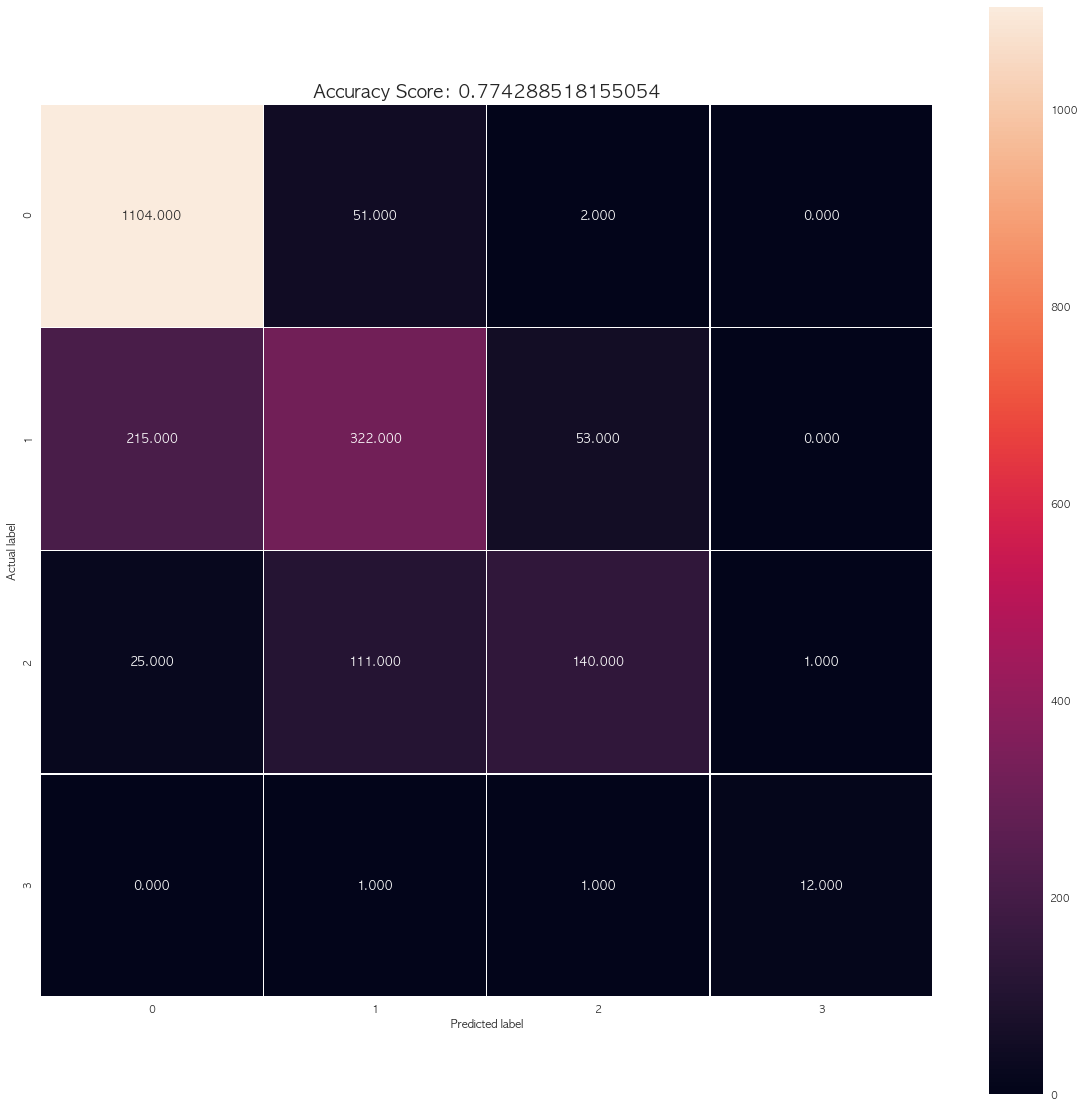

In [157]:
plt.figure(figsize=(20,20)) # chart size 
sns.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

#### 종속변수 범주화 
##### 0-3= 0, 4-7 = 1, 8-10 = 2

In [158]:
new_grid['폭력빈도_3'] = 0

In [159]:
#new_grid.loc[(new_grid['GRADE_폭력']==0),'폭력빈도'] = 0
new_grid.loc[(new_grid['GRADE_폭력']>=0)&(new_grid['GRADE_폭력']<4),'폭력빈도_3'] = 0
new_grid.loc[(new_grid['GRADE_폭력']>=4)&(new_grid['GRADE_폭력']<8),'폭력빈도_3'] = 1
new_grid.loc[(new_grid['GRADE_폭력']>=8)&(new_grid['GRADE_폭력']<11),'폭력빈도_3'] = 2

In [160]:
new_grid['폭력빈도_3'].value_counts()

0    1747
1     277
2      14
Name: 폭력빈도_3, dtype: int64

In [161]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','폭력빈도_3','폭력빈도_4']).columns)
feature = new_grid[feature_list]
target = new_grid[['폭력빈도_3']]

In [162]:
feature_list

['총인구',
 '유소년인구',
 '고령인구',
 '건축물(30_34)',
 '건축물(35)',
 '개별주택가격',
 '공시지가',
 '가로등',
 '공영주차장',
 '공중화장실',
 '교육시설',
 '대규모점포',
 '대부업현황',
 '룸살롱',
 '버스정류장',
 '보안등',
 '상가',
 '숙박업소',
 '술집',
 '어린이보호',
 '어린이집',
 '오락시설',
 '원룸_오피스텔',
 '음식점',
 '자율방범대',
 '파출소',
 'cctv',
 '신호등',
 '횡단보도',
 '성폭력취약인구',
 '건축물(30_)']

### 다항로지스틱분석

In [163]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.8974484789008832


array([[1683,   64,    0],
       [ 142,  134,    1],
       [   1,    1,   12]])

In [164]:
from sklearn.metrics import classification_report
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1747
           1       0.67      0.48      0.56       277
           2       0.92      0.86      0.89        14

    accuracy                           0.90      2038
   macro avg       0.84      0.77      0.80      2038
weighted avg       0.89      0.90      0.89      2038



In [165]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','폭력빈도_4','폭력빈도_3']).columns)
    feature = df_train[feature_list]
    target = df_train[['폭력빈도_3']]
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['폭력빈도_3'],y_pred2)
    
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.89754601, 검증 Accuracy = 0.89215686
학습 Accuracy = 0.90552147, 검증 Accuracy = 0.87745098
학습 Accuracy = 0.89570552, 검증 Accuracy = 0.88970588
학습 Accuracy = 0.90067443, 검증 Accuracy = 0.89189189
학습 Accuracy = 0.90128755, 검증 Accuracy = 0.89189189
[0.89215686 0.87745098 0.88970588 0.89189189 0.89189189]


0.888619501854796

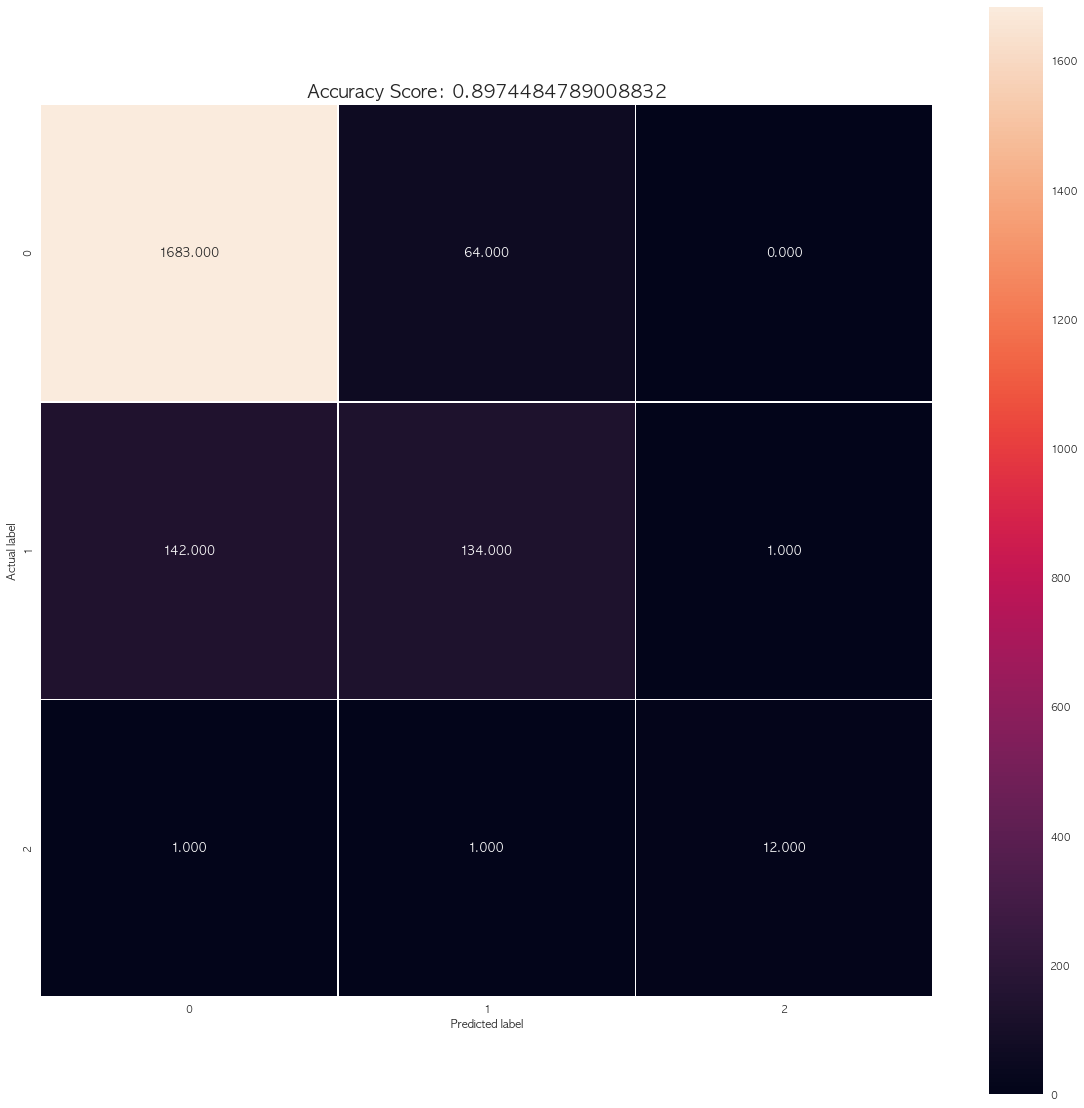

In [166]:
plt.figure(figsize=(20,20)) # chart size 
sns.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

In [167]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_폭력', 'GRADE_절도',
       'GRADE_성폭력', '성폭력취약인구', '건축물(30_)', '폭력빈도_4', '폭력빈도_3'],
      dtype='object')

In [168]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','폭력빈도_3']).columns)
feature = new_grid[feature_list]

### AUTO ML을 통한 Accuracy 탐색

In [169]:
from pycaret.classification import *

In [170]:
# 'voted' 컬럼이 예측 대상이므로 target 인자에 명시
# 'voted' column is the target variable
clf = setup(data = feature,
            train_size = 0.7,
            target = '폭력빈도_4',
            use_gpu = False, 
            session_id = 2021,
           fold_shuffle = True)

,Description,Value
0,session_id,2021
1,Target,폭력빈도_4
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 2: 2, 3: 3"
4,Original Data,"(2038, 32)"
5,Missing Values,False
6,Numeric Features,29
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [171]:
best_5 = compare_models(sort = 'Accuracy', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7742,0.7082,0.5483,0.7587,0.7611,0.5817,0.5865,0.3810
et,Extra Trees Classifier,0.7665,0.7057,0.5218,0.7519,0.7542,0.5686,0.5731,0.2920
catboost,CatBoost Classifier,0.7665,0.7034,0.5527,0.7520,0.7554,0.5702,0.5743,6.7020
lr,Logistic Regression,0.7595,0.7040,0.5825,0.7432,0.7450,0.5502,0.5575,0.8390
gbc,Gradient Boosting Classifier,0.7574,0.7022,0.5610,0.7445,0.7471,0.5550,0.5591,1.1460
lightgbm,Light Gradient Boosting Machine,0.7532,0.6927,0.5465,0.7431,0.7448,0.5519,0.5550,2.0740
xgboost,Extreme Gradient Boosting,0.7462,0.6938,0.5415,0.7352,0.7376,0.5377,0.5407,1.5020
ridge,Ridge Classifier,0.7427,0.0000,0.5037,0.7211,0.7176,0.5027,0.5193,0.0350
lda,Linear Discriminant Analysis,0.7350,0.6949,0.6104,0.7140,0.7150,0.5025,0.5137,0.0290
svm,SVM - Linear Kernel,0.7258,0.0000,0.5358,0.7077,0.7092,0.4930,0.4995,0.0340


In [69]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7692,0.8904,0.6338,0.7579,0.7568,0.5674,0.5758
1,0.7789,0.8998,0.5157,0.7740,0.7752,0.6003,0.6014
2,0.7825,0.8595,0.7386,0.7670,0.7682,0.5925,0.5995
3,0.7754,0.8918,0.4973,0.7576,0.7646,0.5864,0.5891
4,0.8105,0.9082,0.5157,0.7955,0.7975,0.6492,0.6531
Mean,0.7833,0.8899,0.5802,0.7704,0.7725,0.5992,0.6038
SD,0.0143,0.0165,0.0929,0.0140,0.0139,0.0273,0.0263


In [70]:
rf = create_model('rf', cross_validation=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7483,0.8815,0.4850,0.7287,0.7351,0.5321,0.5364
1,0.7902,0.8927,0.5341,0.7797,0.7791,0.6062,0.6136
2,0.7972,0.8953,0.5324,0.7837,0.7891,0.6295,0.6313
3,0.7692,0.8913,0.7347,0.7579,0.7616,0.5797,0.5813
4,0.7972,0.8824,0.5246,0.7883,0.7861,0.6207,0.6264
5,0.7483,0.8361,0.4679,0.7237,0.7306,0.5314,0.5386
6,0.7535,0.0000,0.6093,0.7316,0.7356,0.5368,0.5439
7,0.7535,0.0000,0.6350,0.7454,0.7469,0.5540,0.5555
8,0.7958,0.9017,0.4886,0.7851,0.7767,0.6176,0.6245
9,0.7887,0.9006,0.4715,0.7630,0.7700,0.6091,0.6135


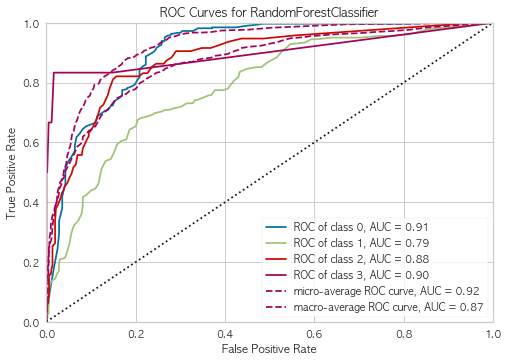

In [71]:
plot_model(rf)

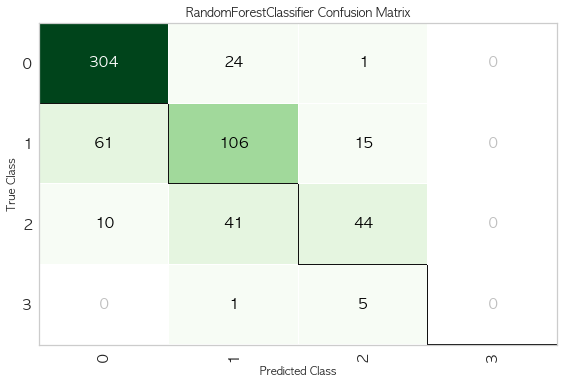

In [72]:
plot_model(rf, plot='confusion_matrix')

In [73]:
evaluate_model(rf)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


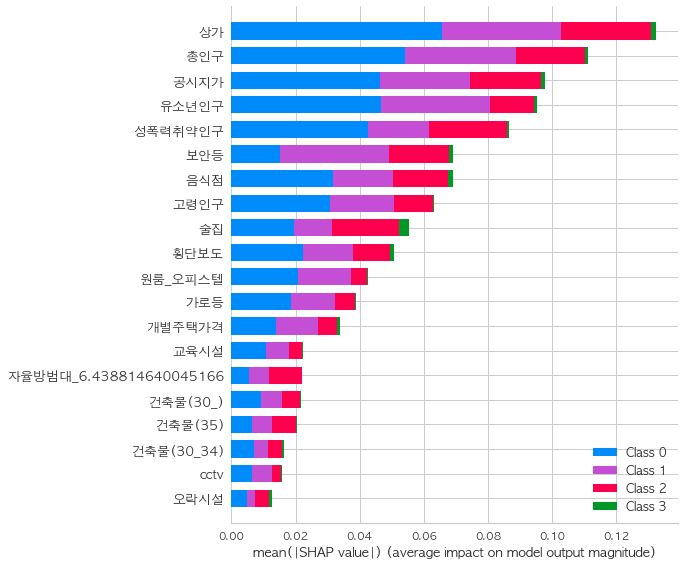

In [74]:
interpret_model(rf)

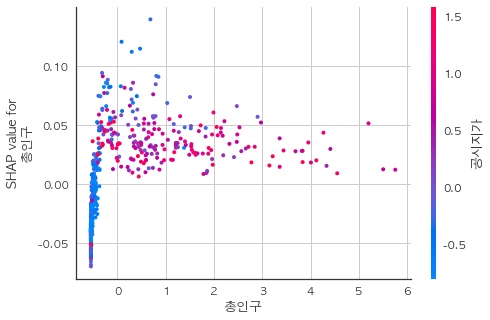

In [75]:
interpret_model(rf, plot='correlation')


In [76]:
py_data = feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','폭력빈도_4']).columns)
feature = new_grid[feature_list]

In [77]:
# 'voted' 컬럼이 예측 대상이므로 target 인자에 명시
# 'voted' column is the target variable
clf = setup(data = feature,
            train_size = 0.7,
            target = '폭력빈도_3',
            use_gpu = False, 
            session_id = 2021,
           fold_shuffle = True)

,Description,Value
0,session_id,2021
1,Target,폭력빈도_3
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 2: 2"
4,Original Data,"(2038, 32)"
5,Missing Values,False
6,Numeric Features,29
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


In [78]:
best_5 = compare_models(sort = 'Accuracy', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8983,0.7457,0.5123,0.8403,0.8146,0.5089,0.5171,5.3330
lightgbm,Light Gradient Boosting Machine,0.8969,0.7352,0.5108,0.8242,0.8084,0.4981,0.5064,1.3400
xgboost,Extreme Gradient Boosting,0.8948,0.7398,0.5322,0.8108,0.7982,0.4916,0.4976,1.3080
gbc,Gradient Boosting Classifier,0.8913,0.7388,0.5739,0.8252,0.8110,0.4868,0.4917,0.6570
rf,Random Forest Classifier,0.8899,0.7314,0.4486,0.8274,0.7961,0.4511,0.4651,0.3220
ridge,Ridge Classifier,0.8892,0.0000,0.4816,0.8107,0.7706,0.4163,0.4349,0.0280
lr,Logistic Regression,0.8885,0.7299,0.5434,0.8118,0.7891,0.4548,0.4637,0.0840
svm,SVM - Linear Kernel,0.8885,0.0000,0.5539,0.8092,0.7980,0.4465,0.4557,0.0210
et,Extra Trees Classifier,0.8829,0.7330,0.4133,0.8133,0.7694,0.3934,0.4113,0.7650
dt,Decision Tree Classifier,0.8772,0.5883,0.5418,0.8033,0.7985,0.4512,0.4563,0.5360


In [79]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9021,0.9505,0.5051,0.8912,0.8963,0.5463,0.5489
1,0.8526,0.8882,0.4275,0.8392,0.8454,0.3097,0.3117
2,0.8947,0.9116,0.4897,0.8848,0.8890,0.5069,0.5102
3,0.8807,0.8699,0.6148,0.8678,0.8718,0.4149,0.4225
4,0.8982,0.9432,0.4720,0.8808,0.8868,0.4868,0.5000
Mean,0.8857,0.9127,0.5018,0.8728,0.8778,0.4529,0.4586
SD,0.0180,0.0310,0.0622,0.0184,0.0181,0.0834,0.0841
